<a href="https://colab.research.google.com/github/MasahiroAraki/MachineLearning3/blob/master/notebook/chap15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U gymnasium --quiet

# 第15章 強化学習

ここでは、強化学習アルゴリズムの勉強や開発のためのライブラリである [Gymnasium](https://gymnasium.farama.org/)の中から、[Frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)問題を対象とします。

## 例題15.1

gymnasium ライブラリを用いて，4x4 のマス目をもつ frozen lake 問題を対象として Q 学習を行え．状態遷移は決定的，すなわち湖面を歩行する場合は，選択した行為が確実に実行されると仮定せよ．

Frozen lakeは凍っている湖面上で、初期状態から出発してゴールを目指す設定です。可能な行為は上下左右の移動（'Left': 0, 'Down': 1, 'Right': 2, 'Up': 3）ですが、湖面が滑るため、確率的に意図した行為と異なる方向に移動してしまいます。ここでは、問題を簡単にするために、滑らない設定（状態遷移が決定的）から始めます。

環境は4×4のタイル状で与えられます。文字はそれぞれのタイルの定義です。

* S: 初期状態
* F: 凍っている湖面（歩行可能）
* H: 穴
* G: ゴール
* 色つきの□: プレイヤーの現在地（開始時はSと重なっている）

In [3]:
# 15章で用いるライブラリ
import numpy as np
import matplotlib.pylab as plt
import gymnasium as gym

In [4]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", render_mode='ansi', is_slippery=False) #滑らない設定
env.reset()
print(env.render()) #現在の環境を表示


SFFF
FHFH
FFFH
HFFG



実行可能な行為数と状態数を確認します。

In [5]:
N_ACT = env.action_space.n
print("Action space: ", N_ACT)

Action space:  4


In [6]:
N_OBS = env.observation_space.n
print("Observation space: ", N_OBS)

Observation space:  16


ランダムに10step (ゴールに着いたり穴に落ちたりしたら終了)動かしてみます。このセルを何度か実行してみて、ランダムな動きではなかなかゴールに着かないことを確認してください。

In [7]:
MAX_ITERATIONS = 10

env.reset()
print(env.render()[0])
for i in range(MAX_ITERATIONS):
    random_action = env.action_space.sample()  #ランダムに行為を選んで
    new_state, reward, terminated, truncated, info = env.step(random_action)  #現在の環境で実行
    done = terminated or truncated
    print(env.render())
    if done:
        break



  (Left)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG



Q学習を試してみます。epsilonは行為選択におけるε-greedy法のパラメータ、gammaは将来報酬の割引率、etaは学習率です。

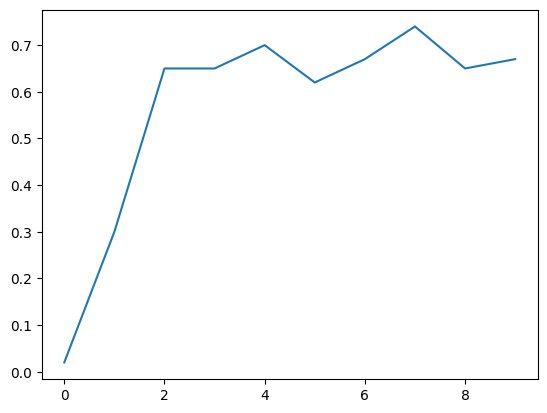

In [8]:
q = np.zeros([N_OBS, N_ACT]) #Q値を0で初期化

#学習時のハイパーパラメータ
EPOCKS = 1000
MAX_ITERATIONS = 100
epsilon = 0.3
gamma = 0.9
eta = 0.9

rewards = np.zeros(EPOCKS) #各エポックでの報酬を記録するarray

for epoch in range(EPOCKS):
    obs = env.reset()[0]
    done = False
    for step in range(MAX_ITERATIONS):
        act = np.argmax(q[obs, :]) #Q値が最大となる行為を求める
        act = np.random.choice(np.where(q[obs, :] == q[obs, act])[0]) #同じ値となるものがあれば、その中からランダムで選択
        if np.random.rand() <= epsilon: #確率epsilonでランダムに行為を選択
            act = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(act) #行為を実行
        done = terminated or truncated
        if not done: #最終状態（GまたはH）ではないか？
            q[obs, act] += eta * (reward - q[obs, act] + gamma * np.max(q[next_obs, :])) #TD法
        else:
            q[obs, act] += eta * (reward - q[obs, act])
        obs = next_obs
        rewards[epoch] = reward
        if done:
            break

rates = np.average(rewards.reshape([EPOCKS//100, 100]), axis = 1) #100エポック毎の報酬の平均値を求める
plt.plot(rates)
plt.savefig('s15-1.svg', format='svg', bbox_inches='tight')
plt.show()

In [9]:
state, _ = env.reset()
env.render()
done = False
print("----- テスト開始 -----")
while not done:
    # Qテーブルに基づき最も良い行動を選択
    action = np.argmax(q[state])
    next_state, reward, terminated, truncated, _ = env.step(action)
    print(env.render())
    done = terminated or truncated
    state = next_state

print("----- テスト終了 -----")

----- テスト開始 -----
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

----- テスト終了 -----


##  例題15.2

例題15.1 の設定に対して，湖面が滑る場合のQ学習を行え．

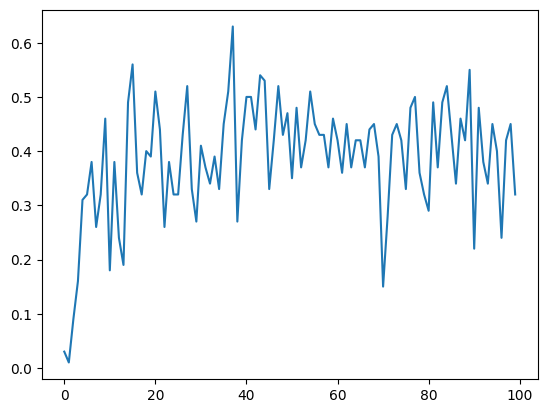

In [10]:
env = gym.make('FrozenLake-v1', desc=["SFFF", "FHFH", "FFFH", "HFFG"], render_mode='ansi', is_slippery=True) #滑る設定
N_ACT = env.action_space.n
N_OBS = env.observation_space.n

q = np.zeros([N_OBS, N_ACT]) #Q値を0で初期化

EPOCKS = 10000
MAX_ITERATIONS = 100
epsilon = 0.01
gamma = 0.9
eta = 0.5

rewards = np.zeros(EPOCKS) #各エポックでの報酬を記録するarray

for epoch in range(EPOCKS):
    obs = env.reset()[0]
    done = False
    for step in range(MAX_ITERATIONS):
        act = np.argmax(q[obs, :]) #Q値が最大となる行為を求める
        act = np.random.choice(np.where(q[obs, :] == q[obs, act])[0]) #同じ値となるものがあれば、その中からランダムで選択
        if np.random.rand() <= epsilon: #確率epsilonでランダムに行為を選択
            act = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(act) #行為を実行
        done = terminated or truncated
        if not done: #最終状態（GまたはH）ではないか？
            q[obs, act] += eta * (reward - q[obs, act] + gamma * np.max(q[next_obs, :])) #TD法
        else:
            q[obs, act] += eta * (reward - q[obs, act])
        obs = next_obs
        rewards[epoch] = reward
        if done:
            break

rates = np.average(rewards.reshape([EPOCKS//100, 100]), axis = 1) #100エポック毎の報酬の平均値を求める
plt.plot(rates)
plt.savefig('s15-3.svg', format='svg', bbox_inches='tight')
plt.show()

問題が難しくなっているのでエポック数を増やします。また、負の報酬が得られやすくなっているので、学習係数をやや低めにすると、平均報酬で0.5程度が実現できます。